# Checks of the finite volume sub-module in the qft module 

In collab. with Max Hansen

In [1]:
import numpy
from scipy.integrate import quad

import matplotlib.pyplot as plt
%matplotlib widget

import pyobs
fv = pyobs.qft.finite_volume
qc = fv.quantization_condition_2to2
nuk = fv.zeta00.nuk

In the following we will use the Gaussian test function

In [2]:
def smear(x,x0,w):
    ww=w*w
    return numpy.exp(-(x-x0)**2/(2*ww))/numpy.sqrt(2*numpy.pi*ww)

First we establish the check

$$
\int \frac{d^3 k}{(2\pi)^3} f(2 \sqrt{1 + k^2}) = 
\int \frac{d k\ k^2}{2\pi^2} f(2 \sqrt{1 + k^2}) = 
lim_{L \to \infty} \sum_{\vec n} f(2 \sqrt{1 + |\vec n|^2 (2\pi/L)^2}) = 
lim_{L \to \infty} \frac{1}{L^3} \sum_k \nu_k f(2 \sqrt{1 + k (2\pi/L)^2})
$$

In [3]:
L = 10

print(quad(lambda x: x**2/(2*numpy.pi**2) * smear(2*numpy.sqrt(1+x*x),2,1), 0, numpy.inf)[0])

def Ek(k,L):
    return 2*numpy.sqrt(1 + k*(2 *numpy.pi/L)**2)

print(1/L**3 * sum([nuk[k,3]*smear(Ek(k,L),2,1) for k in range(100) ]))

0.0180092551788268
0.018009225081245153


Now a slightly less trivial check

$$
k^2 = E^2/4 - 1 \,, \quad 2\sqrt{1 + k^2} = E \quad dk = \frac{E}{4k} dE
$$

$$
\int \frac{d k\ k^2}{2\pi^2} f(2 \sqrt{1 + k^2}) = \int dE \ \frac{E k}{8\pi^2} f(E)
$$

$$
\int dE f(2 \sqrt{1+k^2}) = 
\frac{1}{L^3} lim_{L \to \infty} \sum_k f(2 \sqrt{1 + k (2\pi/L)^2}) 
\frac{8 \pi^2}{(2\pi/L) k^{1/2} \cdot 2 \sqrt{1 + k(2\pi/L)^2}} \nu_k
$$

In [4]:
L = 100

print(quad(lambda x: smear(x,2.5,1), 2 ,numpy.inf)[0])

def pref(k,L):
    if nuk[k,3]==0:
        return 0.0
    return nuk[k,3] / Ek(k,L) / (2*numpy.pi/L * k**0.5)
    
print((8*numpy.pi**2)/L**3 * sum([smear(Ek(k,L),2.5,1) * pref(k,L) for k in range(1,2500)]))

0.6914624612740132
0.690813455352672


So the above gives us the dictionary between an integral in energy and the finite-volume sum.

One can additionally show that the Lellouch-Luescher factor does the following in the non-interacting limit

$$
\Big[ \frac{\partial \phi}{\partial E} \Big]^{-1} =
\frac{1}{L^3} \frac{8 \pi}{k_k E_k} \nu_k
$$

Matching to the resul above gives

$$
\int dE f(2 \sqrt{1+k^2}) = 
lim_{L \to \infty} \sum_k f(2 \sqrt{1 + k (2\pi/L)^2}) \pi \Big[ \frac{\partial \phi}{\partial E} \Big]^{-1}
$$

In [5]:
L = 100

print(quad(lambda x: smear(x,2.5,1), 2, numpy.inf)[0])

def dphidEInverse(k,L):
    return 8*numpy.pi / L**3 * pref(k,L)

print(sum([smear(Ek(k,L),2.5,1) * numpy.pi * dphidEInverse(k,L) for k in range(1,2500)]))

0.6914624612740132
0.690813455352671


In [6]:
L = 100

qcond2 = qc.single_channel(qc.com_frame(), L, 1)
eps = 1 + 1e-8
for k in range(1,25):
    dphi_ex = dphidEInverse(k,L)
    if dphi_ex==0.0:
        continue
    print(f"k = {k}, dphi_num / dphi_exact = {-1.0/qcond2.der_phi(Ek(k,L)*eps)/dphi_ex:g}")

k = 1, dphi_num / dphi_exact = 0.999997
k = 2, dphi_num / dphi_exact = 1
k = 3, dphi_num / dphi_exact = 1.00001
k = 4, dphi_num / dphi_exact = 0.999982
k = 5, dphi_num / dphi_exact = 0.999996
k = 6, dphi_num / dphi_exact = 1.00001
k = 8, dphi_num / dphi_exact = 0.99998
k = 9, dphi_num / dphi_exact = 0.999995
k = 10, dphi_num / dphi_exact = 1
k = 11, dphi_num / dphi_exact = 1.00001
k = 12, dphi_num / dphi_exact = 1
k = 13, dphi_num / dphi_exact = 0.99999
k = 14, dphi_num / dphi_exact = 1
k = 16, dphi_num / dphi_exact = 0.999932
k = 17, dphi_num / dphi_exact = 0.999993
k = 18, dphi_num / dphi_exact = 1
k = 19, dphi_num / dphi_exact = 1.00001
k = 20, dphi_num / dphi_exact = 0.999997
k = 21, dphi_num / dphi_exact = 1
k = 22, dphi_num / dphi_exact = 1.00002
k = 24, dphi_num / dphi_exact = 0.999981


At this point we can easily build smeared finite-volume spectral functions from the original infinite volume one

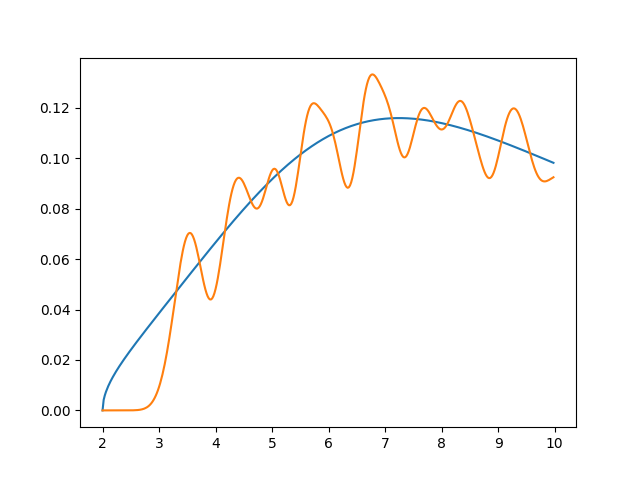

In [7]:
def rho_IV(w):
    return numpy.sqrt(w*w/4-1) / ((w-5)**2 + 25)

L = 10

wax = numpy.arange(2,10,0.02)

def rho_FV(w):
    return sum([rho_IV(Ek(k,L))*smear(Ek(k,L),w,0.2)*numpy.pi * dphidEInverse(k,L)  for k in range(4,80)])

plt.figure()
plt.plot(wax, rho_IV(wax))
plt.plot(wax, [rho_FV(w) for w in wax])